In [1]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.utils import to_categorical

from keras import backend as K
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *

In [2]:
FIG_WIDTH=20 # Width of figure
ROW_HEIGHT=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

In [3]:
data_dir=os.path.join('..','input/numta')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [4]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
#         img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
#         X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [5]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [6]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 28, 28), (72045, 10))

In [7]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [8]:


X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))



In [9]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

(28, 28)

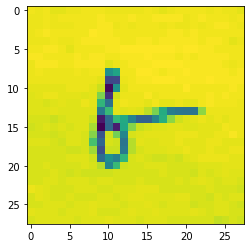

In [10]:
plt.imshow(X_train[0])
X_train[0].shape

In [11]:
y_train_new=y_train.argmax(axis=1)
y_train_new.shape
print(y_train_new.shape)
y_train=y_train_new


(57636,)


In [12]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=10, output_dim=10)(label_input)
x = Reshape((10,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
# generator.summary()

In [13]:
img_input = Input(shape=(28,28,))
x = Reshape((28,28,1))(img_input)
x = Conv2D(16, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(11, activation='softmax')(x)
discriminator = Model(inputs=img_input, outputs=x)
# discriminator.summary()

In [14]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 28, 28)       789221      latent_input[0][0]               
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
model_1 (Functional)            (None, 11)           103755      model[0][0]                

In [15]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [16]:
def random_mnist_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(10, size=size)})

In [17]:
save_interval = 300
epochs = save_interval*10+1
batch_size=20
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_mnist_set(X_train, y_train, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))
    
    discriminator.trainable=False
    
    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels}, 
                       gan_labels)
    
    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('generator_{0:05d}.h5'.format(iteration))

generator: loss=2.402299404144287. acc=0.0
discriminator: loss_real=3.560966968536377, acc_real=0.05000000074505806
    loss_fake=4.124524116516113, acc_fake=0.0
generator: loss=2.9242539405822754. acc=0.10000000149011612
discriminator: loss_real=2.62793231010437, acc_real=0.20000000298023224
    loss_fake=0.0059715681709349155, acc_fake=1.0
generator: loss=4.456226348876953. acc=0.10000000149011612
discriminator: loss_real=2.945681571960449, acc_real=0.10000000149011612
    loss_fake=0.011922704055905342, acc_fake=1.0
generator: loss=4.111684322357178. acc=0.10000000149011612
discriminator: loss_real=2.439990282058716, acc_real=0.25
    loss_fake=0.00784886535257101, acc_fake=1.0
generator: loss=4.6684980392456055. acc=0.10000000149011612
discriminator: loss_real=2.7223563194274902, acc_real=0.15000000596046448
    loss_fake=0.0023969020694494247, acc_fake=1.0
generator: loss=4.480887413024902. acc=0.10000000149011612
discriminator: loss_real=1.5631662607192993, acc_real=0.44999998807

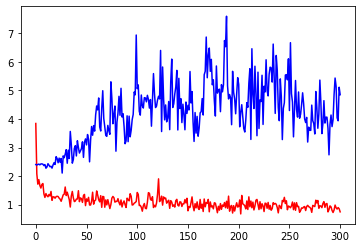

In [18]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

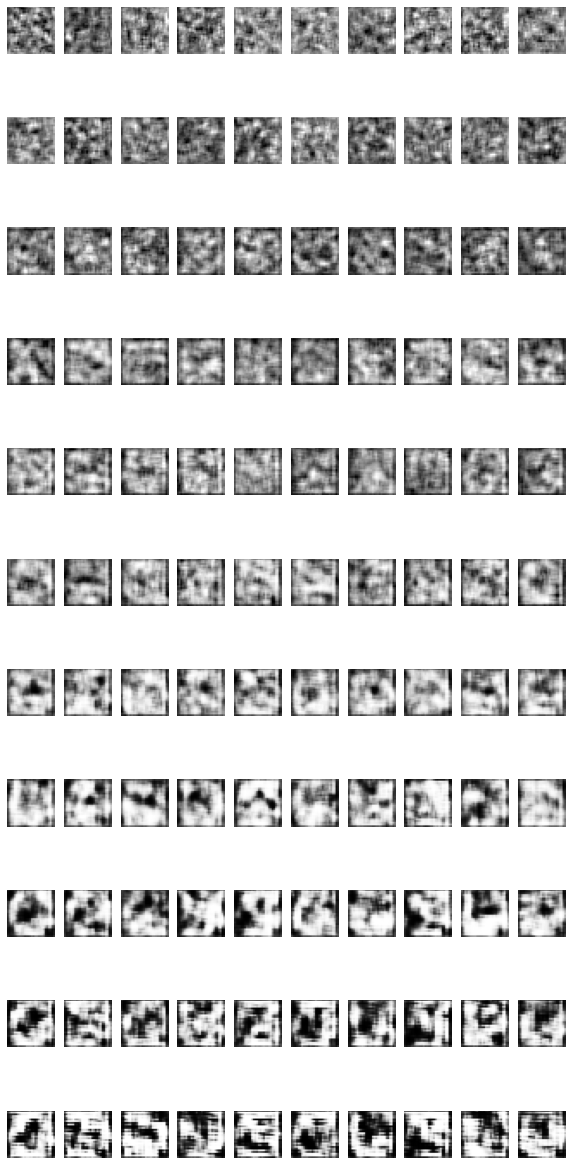

In [19]:
checkpoints = sorted(glob.glob('generator_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

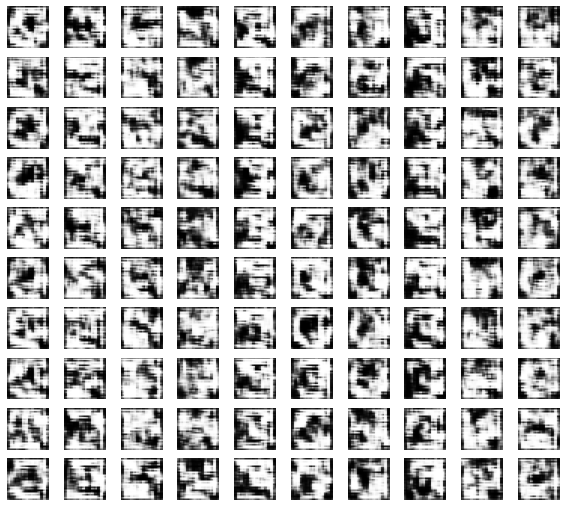

In [20]:

generator.load_weights(checkpoints[-1])
plt.figure(figsize=(10,10))
for i in range(10):
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')
